In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import sidetable as stb
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices
from sklearn.linear_model import LinearRegression

## PreProcessing

### Récupération des données

#### Chargement des données

In [2]:
df_data = pd.read_csv("https://simplonline-v3-prod.s3.eu-west-3.amazonaws.com/media/file/csv/2120d261-1446-43e8-b0eb-a681e66d738a.csv",
                     sep=";")

#### Enregistrement des données au format csv

In [3]:
df_data.to_csv("data.csv")

### Exploration des données

#### Exploration générale du dataset

In [4]:
df_viz = df_data.copy()

On crée une copie de notre jeu de données pour être certain de ne pas le modifier pendant la phase d'exploration.

In [5]:
df_data.shape

(50, 5)

Notre jeu de données comprend 50 lignes et 5 colonnes. Nous disposons de peu de données.

In [6]:
df_data.head()

,R&D,Administration,Marketing,villes,Profit
0,165349.20,136897.80,471784.10,Paris,192261.83
1,162597.70,151377.59,443898.53,Strasbourg,191792.06
2,153441.51,101145.55,407934.54,Lyon,191050.39
3,144372.41,118671.85,383199.62,Paris,182901.99
4,142107.34,91391.77,366168.42,Lyon,166187.94


In [7]:
df_data.dtypes

R&D               float64
Administration    float64
Marketing         float64
villes             object
Profit            float64
dtype: object

Notre jeu de données comprend quatre variables indépendantes et notre variable dépendante (le Profit). Elles sont toutes de type numérique float64 et quantitatives, sauf la variable ville qui est une variable de type objet et qui comprend des données catégorielles.

In [8]:
df_data.describe()

,R&D,Administration,Marketing,Profit
count,50.000000,50.000000,50.000000,50.000000
mean,73721.615600,121344.639600,211025.097800,112012.639200
std,45902.256482,28017.802755,122290.310726,40306.180338
min,0.000000,51283.140000,0.000000,14681.400000
25%,39936.370000,103730.875000,129300.132500,90138.902500
50%,73051.080000,122699.795000,212716.240000,107978.190000
75%,101602.800000,144842.180000,299469.085000,139765.977500
max,165349.200000,182645.560000,471784.100000,192261.830000


On constate que la médiane est proche de la moyenne. Les données sont équitablement réparties.

In [9]:
df_data.stb.missing()

,missing,total,percent
R&D,0,50,0.0
Administration,0,50,0.0
Marketing,0,50,0.0
villes,0,50,0.0
Profit,0,50,0.0


Il n'y a aucune donné manquante.

#### Exploration de la variable catégorielle "villes"

In [10]:
df_data.villes.nunique()

3

La variable catégorielle 'villes' ne comprend que trois villes différentes.

In [11]:
df_data.villes.value_counts()

Strasbourg    17
Paris         17
Lyon          16
Name: villes, dtype: int64

Les trois villes possibles sont : Paris, Strasbourg et Lyon.

In [12]:
df_data.stb.freq(["villes"])

,villes,count,percent,cumulative_count,cumulative_percent
0,Strasbourg,17,34.0,17,34.0
1,Paris,17,34.0,34,68.0
2,Lyon,16,32.0,50,100.0


La fréquence de chaque ville est homogène au sein du dataset.

#### Exploration des variables numériques

In [13]:
corr_matrix = df_viz.corr() #Création d'une matrice de corrélations

In [14]:
corr_matrix["Profit"].sort_values(ascending=False)

Profit            1.000000
R&D               0.972900
Marketing         0.747766
Administration    0.200717
Name: Profit, dtype: float64

On constate une corrélation linéaire très forte entre les dépenses de R&D et le profit. Il existe aussi une corrélation linéaire entre les dépenses de marketing et le profit mais elle est moins marquée que la précédente.

array([[<AxesSubplot:xlabel='R&D', ylabel='R&D'>,
        <AxesSubplot:xlabel='Marketing', ylabel='R&D'>,
        <AxesSubplot:xlabel='Profit', ylabel='R&D'>],
       [<AxesSubplot:xlabel='R&D', ylabel='Marketing'>,
        <AxesSubplot:xlabel='Marketing', ylabel='Marketing'>,
        <AxesSubplot:xlabel='Profit', ylabel='Marketing'>],
       [<AxesSubplot:xlabel='R&D', ylabel='Profit'>,
        <AxesSubplot:xlabel='Marketing', ylabel='Profit'>,
        <AxesSubplot:xlabel='Profit', ylabel='Profit'>]], dtype=object)

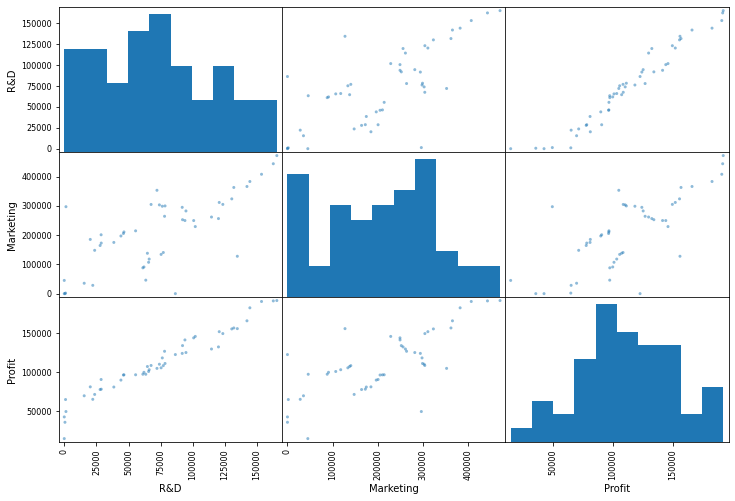

In [15]:
attributes = ['R&D', 'Marketing', 'Profit']
scatter_matrix(df_viz[attributes], figsize=(12, 8))

scatter_matrix nous permet d'afficher les graphes entre plusieurs variables. Ces dernières sont représentées par un nuage de points.

Les graphes viennent confirmer visuellement deux choses. d'une part il n'y a pas de valeurs aberrantes et les données sont équitablement réparties au sein de chaque série (médiane proche de la moyenne). D'autre part, sur les deux graphiques représentant les dépenses de R&D et le profit les nuages de points ont une forme linéaire. Cette dernière constatation nous confirme graphiquement l'existence d'une corrélation linéaire forme entre les dépenses de R&D et le profit.

### Nettoyage

#### Division du jeu de données en jeu d'entrainement et en jeu de test

In [16]:
#Utilisation de la méthode train_test_split de sklearn pour diviser notre dataset
train_set, test_set = train_test_split(df_data, test_size=0.2)

Notre dataset étant très restreint (50 lignes), nous avons choisi de ne conserver que 20% de nos données pour la phase de test.

#### Renommage des colonnes

In [17]:
train_set.columns = ['RD', 'Administration', 'Marketing', 'villes', 'Profit']
train_set.columns

Index(['RD', 'Administration', 'Marketing', 'villes', 'Profit'], dtype='object')

Le symbole '&' pourrait poser problème par la suite. La colonne 'R&D' est renommée 'RD'.

### Transformation de la variable catégorielle villes en variable numérique

In [18]:
train_set['villes'] = pd.factorize(train_set['villes'])[0]

<ipython-input-18-b12191f35b2b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set['villes'] = pd.factorize(train_set['villes'])[0]


Il existe plusieurs méthodes pour transformer une variable catégorielle de type string en type numérique. Nous avons choisi la méthode factorize de pandas, cette dernière bibliothèque étant celle avec laquelle nous sommes le plus à l'aise.

In [19]:
train_set

,RD,Administration,Marketing,villes,Profit
0,165349.20,136897.80,471784.10,0,192261.83
9,123334.88,108679.17,304981.62,1,149759.96
6,134615.46,147198.87,127716.82,1,156122.51
10,101913.08,110594.11,229160.95,2,146121.95
22,73994.56,122782.75,303319.26,2,110352.25
12,93863.75,127320.38,249839.44,2,141585.52
26,75328.87,144135.98,134050.07,2,105733.54
38,20229.59,65947.93,185265.10,0,81229.06
15,114523.61,122616.84,261776.23,0,129917.04
28,66051.52,182645.56,118148.20,2,103282.38


Vérification de la bonne transformation de la variable 'villes' en données numériques.

## Analyse

### Création et optimisation du modèle

#### Création du modèle

In [20]:
mod = smf.ols('Profit~RD+Marketing+Administration+villes', data=train_set)
res = mod.fit()

La méthode ols() de statsmodels.formula.api nous permet d'entraîner notre modèle de régression linéaire multiple et de l'optimiser en deux lignes de code. Pratique.

In [21]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Profit   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     286.7
Date:                Sun, 17 Jan 2021   Prob (F-statistic):           3.21e-26
Time:                        10:19:04   Log-Likelihood:                -409.79
No. Observations:                  40   AIC:                             829.6
Df Residuals:                      35   BIC:                             838.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       4.745e+04   5617.694      8.447      0.000     3.6e+04    5.89e+04
RD                 0.7828      0.039     19.832      0.000       0.703       0.863
Marketing          0.0258      0.015      1.778      0.084      -0.004       0.055
Administration     0.0139      0.044      0.319      0.752      -0.074       0.102
villes           406.4257   1498.541      0.271      0.788   -2635.773    3448.625
==============================================================================
Omnibus:                        0.324   Durbin-Watson:                   2.654
Prob(Omnibus):                  0.850   Jarque-Bera (JB):                0.346
Skew:                           0.194   Prob(JB):                        0.841
Kurtosis:                       2.761   Cond. No.                     1.34e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.34e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Puis la méthode summary() nous affiche les statistiques relatives à notre modèle. Deux informations nous intéresse particulièrement à cette étape : le adjusted R-squared et la P value.

#### Sélection des variables avec la méthode backward elimination

On voit que la p_value est la plus mauvaise pour les villes (0,905). Elle est bien au dessus de notre seuil de significativité de 5%. Nous allons réentraîner notre modèle sans cette variable. et vérifier si le R-squared augmente ou diminue.

In [22]:
mod = smf.ols('Profit~RD+Marketing+Administration', data=train_set)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Profit   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     392.3
Date:                Sun, 17 Jan 2021   Prob (F-statistic):           1.54e-27
Time:                        10:19:04   Log-Likelihood:                -409.83
No. Observations:                  40   AIC:                             827.7
Df Residuals:                      36   BIC:                             834.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       4.771e+04   5466.797      8.726      0.000    3.66e+04    5.88e+04
RD                 0.7816      0.039     20.184      0.000       0.703       0.860
Marketing          0.0267      0.014      1.908      0.064      -0.002       0.055
Administration     0.0145      0.043      0.337      0.738      -0.073       0.102
==============================================================================
Omnibus:                        0.243   Durbin-Watson:                   2.608
Prob(Omnibus):                  0.886   Jarque-Bera (JB):                0.214
Skew:                           0.157   Prob(JB):                        0.898
Kurtosis:                       2.826   Cond. No.                     1.32e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.32e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Notre R-squared a légèrement augmenté, passant de 0,945 à 0,947. On constate que le p-value de administration reste très au-dessus de notre seuil de significativité (0,402).

Nous allons réentraîner notre modèle sans la variable Administration.

In [23]:
mod = smf.ols('Profit~RD+Marketing', data=train_set)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Profit   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     602.9
Date:                Sun, 17 Jan 2021   Prob (F-statistic):           5.83e-29
Time:                        10:19:04   Log-Likelihood:                -409.89
No. Observations:                  40   AIC:                             825.8
Df Residuals:                      37   BIC:                             830.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.938e+04   2242.592     22.021      0.000    4.48e+04    5.39e+04
RD             0.7867      0.035     22.348      0.000       0.715       0.858
Marketing      0.0252      0.013      1.922      0.062      -0.001       0.052
==============================================================================
Omnibus:                        0.162   Durbin-Watson:                   2.603
Prob(Omnibus):                  0.922   Jarque-Bera (JB):                0.107
Skew:                           0.108   Prob(JB):                        0.948
Kurtosis:                       2.867   Cond. No.                     5.05e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.05e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Nous pouvont constaté que la variable Marketing a une P value de 0,114, soit au-dessus de notre seuil de significativité de 5%.

Nous allons réentraîner notre modèle sans la variable Marketing.

In [24]:
mod = smf.ols('Profit~RD', data=train_set)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Profit   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     1123.
Date:                Sun, 17 Jan 2021   Prob (F-statistic):           8.01e-30
Time:                        10:19:04   Log-Likelihood:                -411.79
No. Observations:                  40   AIC:                             827.6
Df Residuals:                      38   BIC:                             831.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5.089e+04   2174.022     23.409      0.000    4.65e+04    5.53e+04
RD             0.8360      0.025     33.504      0.000       0.785       0.886
==============================================================================
Omnibus:                        0.020   Durbin-Watson:                   2.620
Prob(Omnibus):                  0.990   Jarque-Bera (JB):                0.077
Skew:                           0.027   Prob(JB):                        0.962
Kurtosis:                       2.791   Cond. No.                     1.63e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.63e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Nous constatons que le R-squared a légèrement diminué en n'utilisant pas la variable Marketing pour générer notre modèle. Néanmoins, retirer une variable implique une perte de précision dans les prédictions. Il s'agit de prédictions pour de l'investissement. Nous avons préféré priviligier la précision de notre modèle et accepter un risque plus important. Ainsi, malgré le fait que la P value de la variable Marketing soit au-dessus de notre seuil de significativité, nous avons choisi de la conserver pour élaborer notre modèle.

#### Génération et entraînement de notre modèle optimisé

In [25]:
regressor = LinearRegression()

In [26]:
regressor.fit(train_set[['RD', 'Marketing']], train_set['Profit'])

LinearRegression()

#### Affichage des paramètres du modèle

In [27]:
regressor.intercept_

49383.39060801163

In [28]:
regressor.coef_

array([0.7867012 , 0.02517924])

Notre modèle est une droite dans m'équation prend la forme suivante : y = a0 + a1x1 + a2x2 avec x1 et x2 qui sont respectivement les variables indépendantes R&R et Marketing, y qui représente notre variable dépendante profit et a0, a1 et a2 qui sont les paramètres de notre modèle. On peut voir des dernières lignes de code que a0 = 47828.61882303079 a1 = 0.79139182 et a2 = 0.02994804.

## Prédictions

In [29]:
#Modification des noms de colonnes dans le set de test
test_set.columns = ['RD', 'Administration', 'Marketing', 'villes', 'Profit']

In [30]:
#Modification des noms de ville en variable numérique dans le set de test
test_set['villes'] = pd.factorize(test_set['villes'])[0]

<ipython-input-30-1c58cb6a69fb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['villes'] = pd.factorize(test_set['villes'])[0]


In [31]:
#Calcul des prédictions à partir de notre modèle
profit_predictions = regressor.predict(test_set[['RD', 'Marketing']])

In [32]:
#Enregistrement des prédictions et du bénéfice réel
df_test = pd.DataFrame({"prediction":profit_predictions, "profit": test_set['Profit']})

In [33]:
df_test

,prediction,profit
36,76997.424821,90708.19
11,134870.519811,144259.40
3,172610.013190,182901.99
49,50520.813752,14681.40
27,115003.424940,105008.31
14,150201.681389,132602.65
17,130965.297684,125370.37
23,110185.157129,108733.99
29,103692.963325,101004.64
35,90757.452758,96479.51


On constate que les données prédites par notre modèle sont proches des données réelles.